In [1]:
! pip install torch==2.5.1 torchaudio==2.5.1 torchvision==0.20.1 triton==3.1.0
! pip install open_clip_torch==2.30.0
! pip install transformers==4.47.0 bitsandbytes==0.45.0

  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchaudio-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manyli

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

from PIL import Image

import torch
from torchvision import transforms

# OpenCLIP
import open_clip
from open_clip import tokenizer

# 事前学習済みモデルを確認
open_clip.list_pretrained()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [2]:
# GPUかCPUかを変数へ
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# モデルの読み込み（初回はダウンロード）
model, _, transform = open_clip.create_model_and_transforms(
  'coca_ViT-L-14', pretrained='mscoco_finetuned_laion2B-s13B-b90k',
  device=device)
model.eval() # 推論モードへ

print('### Model parameters:', f'{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}')
print('### transform:\n', transform) # 前処理

### Model parameters: 638,450,177
### transform:
 Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f68b4fe48b0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


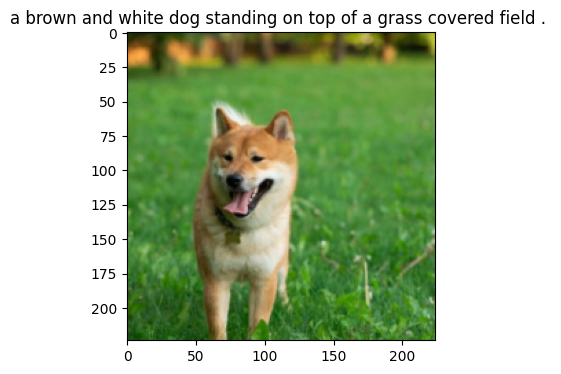

In [3]:
def generate_text_coca(img):
  image_input = transform(img).unsqueeze(0).to(device)
  with torch.no_grad(), torch.amp.autocast(device):
    generated_tokens = model.generate(image_input, seq_len=20)
  generated = open_clip.decode(generated_tokens[0].detach())
  caption = generated.split('<end_of_text>')[0].replace('<start_of_text>', '')
  return caption

# 可視化用にリサイズと切り出し処理を定義
trans = transforms.Compose([
  transforms.Resize(224),
  transforms.CenterCrop(224)
])

image_path = 'app/images/dog.jpg' # 入力画像のファイル名を記述
plt.figure(figsize=(4, 4))
img = Image.open(image_path) # 画像を読み込み
plt.imshow(trans(img))
plt.title(generate_text_coca(img)) # 生成実行
plt.show()

In [4]:
from transformers import pipeline
from transformers import BitsAndBytesConfig

model_id = 'llava-hf/llava-v1.6-mistral-7b-hf'
quantization_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_compute_dtype=torch.float16)
pipe = pipeline('image-text-to-text', model=model_id,
  model_kwargs={'quantization_config': quantization_config,
                 'low_cpu_mem_usage': True})

def generate_text_llava(img):
  prompt = '[INST] <image>\nWhat is shown in this image? [/INST]'
  generated = pipe(images=img, text=prompt,
    generate_kwargs={'max_new_tokens': 200})[0]['generated_text']
  caption = generated.split('[/INST]')[1].strip()
  return caption

print(f'\n[{generate_text_llava(img)}]') # 画像が変数imgに読み込み済みと仮定

ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install 'accelerate>=0.26.0'`